In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.ma.core import indices
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [2]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: /root/.kaggle/kaggle.json: No such file or directory


In [3]:
import pathlib
from torchvision.datasets import Food101
from torchvision.transforms import v2

data_path = "/Users/denizkonuk/Pytorch/pytorch/data/food-101/"
data_path = pathlib.Path(data_path)



train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

food101_train = Food101(root=data_path, split="train", download=False, transform=train_transforms)
food101_test = Food101(root=data_path, split="test", download=False, transform=test_transforms)

#print(f"Number of training samples: {len(food101_train)}")
#print(f"Number of test samples: {len(food101_test)}")

In [6]:
import random
all_classes = food101_train.classes
num_classes_to_use = 3
len(food101_train.classes)
print(random.sample(range(len(all_classes)), num_classes_to_use))

[10, 33, 72, 40, 4, 69, 26, 46, 28, 62]


In [7]:
from torch.utils.data import Subset
# Select random classes for training to decrease the dataset size
import random

all_classes = food101_train.classes
num_classes_to_use = 3 # Change this value to the number of classes you want to use
random_classes = random.sample(range(len(all_classes)), num_classes_to_use)

def filter_dataset(dataset, class_indices_to_keep):
    original_len = len(dataset)
    class_names_to_keep = [dataset.classes[i] for i in class_indices_to_keep]

    indices = []
    new_targets = []
    for i in range(len(dataset)):
        if dataset[i][1] in class_indices_to_keep:
            indices.append(i)
            new_targets.append(class_indices_to_keep.index(dataset[i][1]))

    filtered_dataset = Subset(dataset, indices)

    # Create a new attribute to store the remapped targets
    filtered_dataset.targets = new_targets

    # Update the classes attribute
    filtered_dataset.classes = class_names_to_keep

    # Create a new class_to_idx attribute
    filtered_dataset.class_to_idx = {cls: idx for idx, cls in enumerate(class_names_to_keep)}

    # Add a method to get items with remapped labels
    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        label = self.targets[idx]
        return image, label

    filtered_dataset.__getitem__ = __getitem__.__get__(filtered_dataset)

    print(f"Original dataset size: {original_len}")
    print(f"Filtered dataset size: {len(filtered_dataset)}")
    print(f"Number of classes kept: {len(class_indices_to_keep)}")
    print(f"Classes: {filtered_dataset.classes}")

    return filtered_dataset


# Create and filter datasets
food101_train = Food101(root=data_path, split="train", download=False, transform=train_transforms)
food101_test = Food101(root=data_path, split="test", download=False, transform=test_transforms)

food101_train_filtered = filter_dataset(food101_train, random_classes)
food101_test_filtered = filter_dataset(food101_test, random_classes)



Original dataset size: 75750
Filtered dataset size: 2250
Number of classes kept: 3
Classes: ['scallops', 'nachos', 'foie_gras']
Original dataset size: 25250
Filtered dataset size: 750
Number of classes kept: 3
Classes: ['scallops', 'nachos', 'foie_gras']


In [8]:

print(f"Number of training samples: {len(food101_train_filtered)}")
print(f"Number of test samples: {len(food101_test_filtered)}")

Number of training samples: 2250
Number of test samples: 750


In [9]:
print("Clases in the filtered dataset:")
for class_name in food101_train_filtered.classes:
    print(class_name)

Clases in the filtered dataset:
scallops
nachos
foie_gras


In [10]:
print("Random classes selected:")
print(random_classes)
print(f"Number of random classes: {len(random_classes)}")

Random classes selected:
[87, 66, 39]
Number of random classes: 3


In [11]:
import random
from PIL import Image
sample_idx = 2507
img, label = food101_train[sample_idx]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Class name: {food101_train.classes[label]}")

Image shape: torch.Size([3, 224, 224])
Label: 86
Class name: sashimi


In [12]:
print("Class names:")
print(food101_train_filtered.classes)  # Print first 10 class names
print(food101_test_filtered.classes)

Class names:
['scallops', 'nachos', 'foie_gras']
['scallops', 'nachos', 'foie_gras']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


IndexError: list index out of range

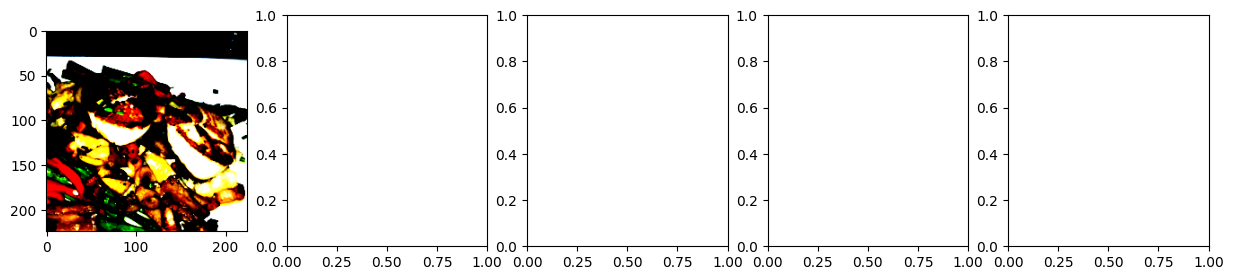

In [13]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        idx = torch.randint(0, len(dataset), (1,)).item()
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        axes[i].set_title(dataset.classes[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_images(food101_train_filtered)

In [14]:
# Create DataLoaders

train_loader = DataLoader(dataset=food101_train_filtered, batch_size=64, shuffle=True, num_workers=12)
test_loader = DataLoader(dataset=food101_test_filtered, batch_size=64, shuffle=False, num_workers=12)

In [15]:
# Let's create a model
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units*2,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(food101_train_filtered.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=3, bias=True)
  )
)

In [16]:
# Use torchinfo to get an idea of the model
from torchinfo import summary
summary(model_0, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 128, 224, 224]        73,856
│    └─ReLU: 2-4                         [1, 128, 224, 224]        --
│    └─Conv2d: 2-5                       [1, 64, 224, 224]         73,792
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 64, 112, 112]         36,928
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-10                      [1, 64, 112, 112]         36,

In [17]:
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=len(food101_train_filtered.classes)).to(device)

In [18]:
# Create a train step

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        #Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [19]:
# Let's create the test step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0


    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(test_pred, y)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [20]:
# Combine train and test functions

from tqdm import tqdm

# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 50):

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    # Loop through training and test steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        #Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # Return the filled results at the end of the epochs
    return results


In [21]:
#Time to train the model

torch.manual_seed(42)
torch.mps.manual_seed(42)

NUM_EPOCHS = 50

#Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(food101_train_filtered.classes)).to(device)

#Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

#Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:53<43:29, 53.26s/it]

Epoch: 1 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


  4%|▍         | 2/50 [01:46<42:30, 53.13s/it]

Epoch: 2 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


  6%|▌         | 3/50 [02:40<41:52, 53.45s/it]

Epoch: 3 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


  8%|▊         | 4/50 [03:33<41:01, 53.52s/it]

Epoch: 4 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


 10%|█         | 5/50 [04:27<40:19, 53.76s/it]

Epoch: 5 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


 12%|█▏        | 6/50 [05:22<39:37, 54.03s/it]

Epoch: 6 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


 14%|█▍        | 7/50 [06:17<38:55, 54.32s/it]

Epoch: 7 | train_loss: 0.0000 | train_acc: 0.0000 | test_loss: 0.0000 | test_acc: 0.0000


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/denizkonuk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/denizkonuk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/denizkonuk/Pytorch/myenv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py", line 45, in <module>
    from ._misc import (
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1138, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1078, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1504, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1473, in _get_spec
  File "<frozen importlib._bootstrap_e

KeyboardInterrupt: 

In [30]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)

        model.eval()
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Print some predictions
        if epoch % 5 == 0:
            model.eval()
            with torch.inference_mode():
                x, y = next(iter(test_dataloader))
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                print("Predictions:", torch.argmax(y_pred, dim=1)[:10])
                print("Actual:     ", y[:10])

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

# When calling the training function:
results = train(model_0, train_loader, test_loader, optimizer, loss_fn, epochs=50)

# After training, plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0000 | train_acc: 0.0999 | test_loss: 0.0000 | test_acc: 0.0977


  2%|▏         | 1/50 [00:48<39:42, 48.62s/it]

Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
Actual:      tensor([54, 54, 54, 54, 54, 54, 54, 54, 54, 54], device='mps:0')


  4%|▍         | 2/50 [01:22<31:53, 39.86s/it]

Epoch: 2 | train_loss: 0.0000 | train_acc: 0.0993 | test_loss: 0.0000 | test_acc: 0.0977


  6%|▌         | 3/50 [01:56<29:13, 37.30s/it]

Epoch: 3 | train_loss: 0.0000 | train_acc: 0.0999 | test_loss: 0.0000 | test_acc: 0.0977


  8%|▊         | 4/50 [02:30<27:42, 36.13s/it]

Epoch: 4 | train_loss: 0.0000 | train_acc: 0.1010 | test_loss: 0.0000 | test_acc: 0.0977


 10%|█         | 5/50 [03:05<26:38, 35.52s/it]

Epoch: 5 | train_loss: 0.0000 | train_acc: 0.1016 | test_loss: 0.0000 | test_acc: 0.0977
Epoch: 6 | train_loss: 0.0000 | train_acc: 0.0999 | test_loss: 0.0000 | test_acc: 0.0977


 12%|█▏        | 6/50 [03:54<29:20, 40.02s/it]

Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
Actual:      tensor([54, 54, 54, 54, 54, 54, 54, 54, 54, 54], device='mps:0')


 14%|█▍        | 7/50 [04:29<27:29, 38.36s/it]

Epoch: 7 | train_loss: 0.0000 | train_acc: 0.0993 | test_loss: 0.0000 | test_acc: 0.0977


 16%|█▌        | 8/50 [05:03<26:04, 37.25s/it]

Epoch: 8 | train_loss: 0.0000 | train_acc: 0.0993 | test_loss: 0.0000 | test_acc: 0.0977


 18%|█▊        | 9/50 [05:38<24:50, 36.36s/it]

Epoch: 9 | train_loss: 0.0000 | train_acc: 0.0993 | test_loss: 0.0000 | test_acc: 0.0977


 20%|██        | 10/50 [06:12<23:51, 35.78s/it]

Epoch: 10 | train_loss: 0.0000 | train_acc: 0.0993 | test_loss: 0.0000 | test_acc: 0.0977
Epoch: 11 | train_loss: 0.0000 | train_acc: 0.0999 | test_loss: 0.0000 | test_acc: 0.0977


 22%|██▏       | 11/50 [07:01<25:45, 39.62s/it]

Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
Actual:      tensor([54, 54, 54, 54, 54, 54, 54, 54, 54, 54], device='mps:0')


 22%|██▏       | 11/50 [07:15<25:43, 39.58s/it]
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/denizkonuk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/denizkonuk/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/denizkonuk/Pytorch/myenv/lib/python3.11/site-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort:skip
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/denizkonuk/Pytorch/myenv/lib/python3.11/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/Users/denizkonuk/Pytorch/m

KeyboardInterrupt: 

In [11]:
print(food101_train_filtered.classes)

['ravioli', 'caesar_salad', 'hot_and_sour_soup', 'caprese_salad', 'bruschetta', 'tiramisu', 'chicken_quesadilla', 'donuts', 'french_toast', 'deviled_eggs']


In [12]:
labels = [label for _, label in food101_train_filtered]
print(f"Min label: {min(labels)}, Max label: {max(labels)}")

Min label: 10, Max label: 98
